In [1]:
from link_generation.vae.vae import VAE 
import matplotlib.pyplot as plt 
import torch
import seaborn as sns
from link_generation.potholders.utils import *
import pandas as pd
import torch

/home/nattd/.conda/envs/knotenv/lib/python3.11/site-packages/snappy/pari.py:6: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import parse_version


In [2]:
potholder_size = 9
state = torch.randint(low=0, high=2, size=(1000,potholder_size**2 - 2), dtype=torch.float32)
P = state_to_potholder_pytorch(state)
G = potholder_to_goeritz_pytorch(P)
sig, log_det = goeritz_to_invariants(G)
invariants = torch.cat([sig.unsqueeze(1),log_det.unsqueeze(1)], dim=1).unsqueeze(1)

In [6]:
loader = get_potholder_graph_data_loader(state, invariants, potholder_size, 2, 128, True)
untrained_model = VAE(mean=0, scale=1, potholder_size=potholder_size, latent_embedding_size=3, device='cpu')
trained_model = VAE.load_from_checkpoint('logs/pot2pot_vae_9_k_2_latent_3/version_0/checkpoints/epoch=60-step=38125.ckpt', mean=0, scale=1, potholder_size=potholder_size, latent_embedding_size=3, device='cpu', map_location=torch.device('cpu'))

In [8]:
# see how well the encoder positions latent embeddings with respect to invariants
def plot_encoder_results(model, data_loader, potholder_size) :
    for batch in data_loader :
        z, mu, logvar, invariants = model(batch)
        df = pd.DataFrame({
            'z1': z.detach().numpy()[:,0],
            'z2': z.detach().numpy()[:,1],
            'sig': batch.y.numpy()[:,0],
            'log_det': batch.y.numpy()[:,1]
        })
        break

    sns.scatterplot(data=df, x='z1', y='z2', hue='sig')
    plt.title(f'2D Slice of 3D Latent Embeddings by Original Signature for {potholder_size}x{potholder_size} Potholders')
    plt.show()

    sns.scatterplot(data=df, x='z1', y='z2', hue='log_det')
    plt.title(f'2D Slice of 3D Latent Embeddings By Original Log Determinant for {potholder_size}x{potholder_size} Potholders')
    plt.show()

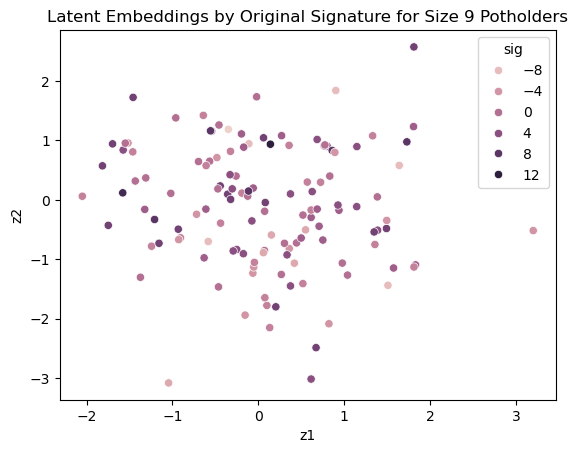

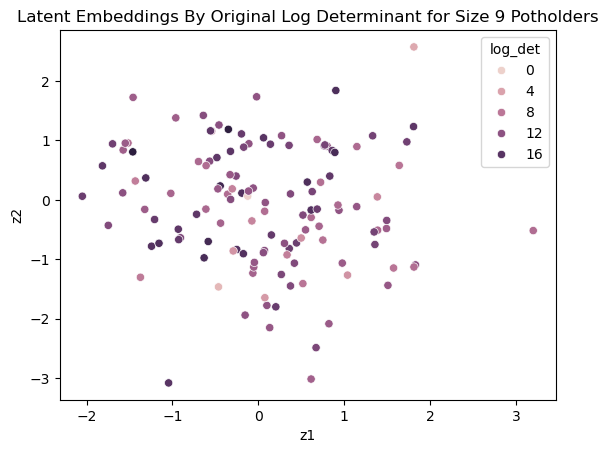

In [5]:
plot_encoder_results(untrained_model, loader, 9)

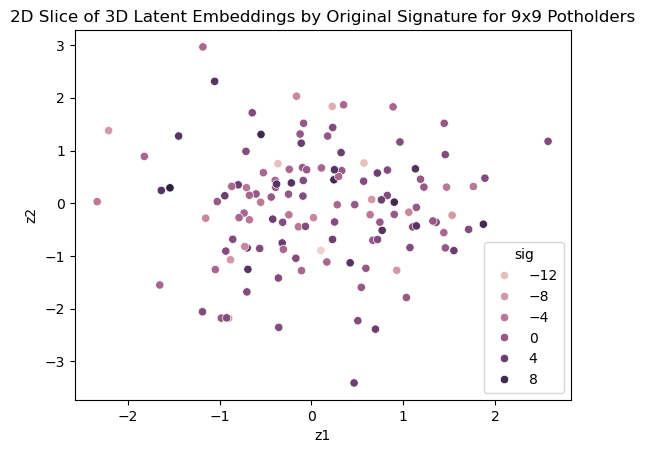

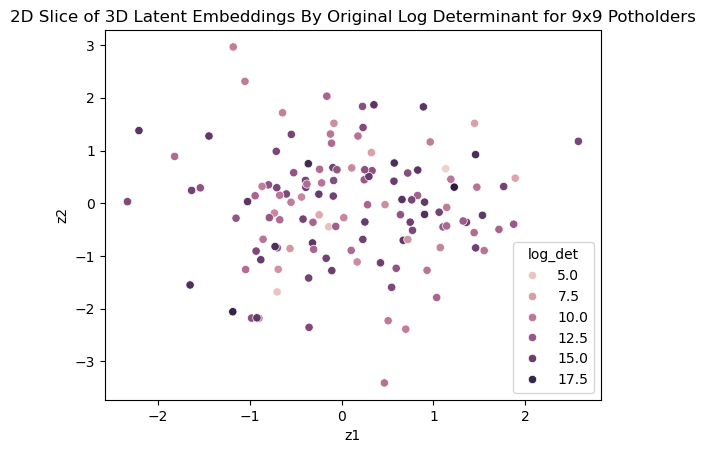

In [9]:
plot_encoder_results(trained_model, loader, 9)

In [23]:
def plot_decoder_results(model, potholder_size, latent_dim) :
    random_latents = torch.randn((256, 2))
    # add a column of zeros to the latents
    random_latents = torch.cat([torch.zeros((256, 1)), random_latents], dim=1)
    sig, log_det = model.latent_to_invariants(random_latents)
    df = pd.DataFrame({
        'z1': random_latents.numpy()[:,1],
        'z2': random_latents.numpy()[:,2],
        'sig': sig.detach().numpy(),
        'log_det': log_det.detach().numpy()
    })

    sns.scatterplot(data=df, x='z1', y='z2', hue='sig')
    plt.title(f'Latent Embeddings by Decoded Signature for Size {potholder_size} Potholders')
    plt.show()

    sns.scatterplot(data=df, x='z1', y='z2', hue='log_det')
    plt.title(f'Latent Embeddings By Decoded Log Determinant for Size {potholder_size} Potholders')
    plt.show()

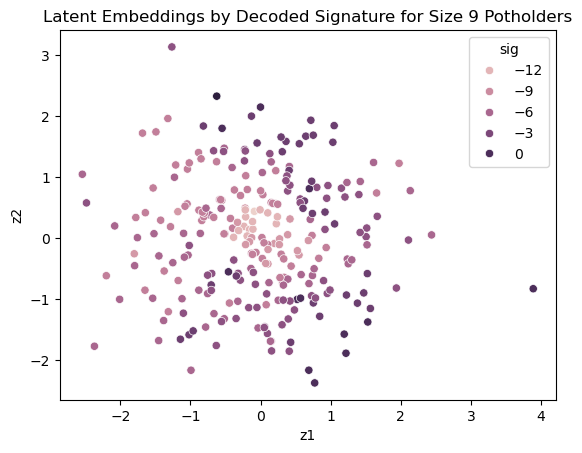

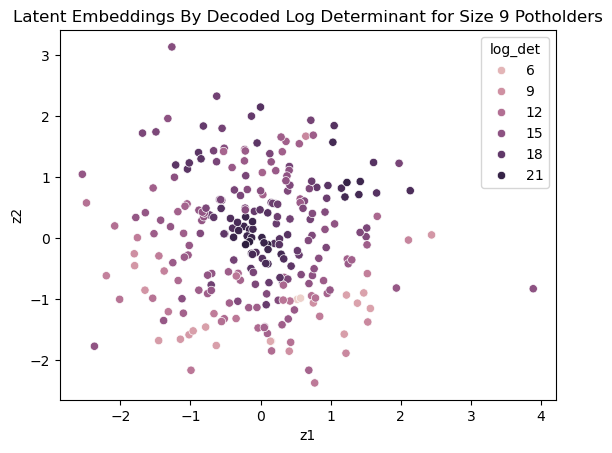

In [25]:
plot_decoder_results(untrained_model, 9, 3)

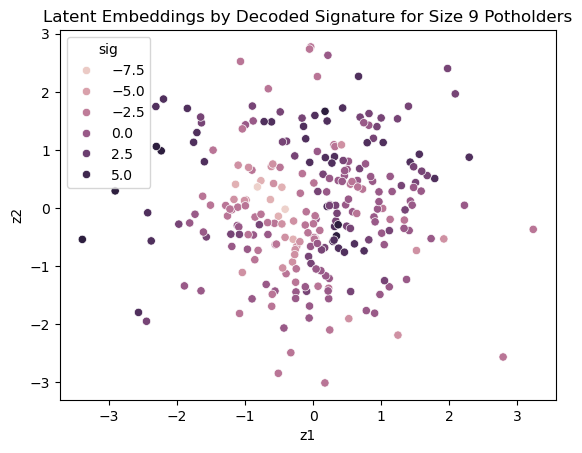

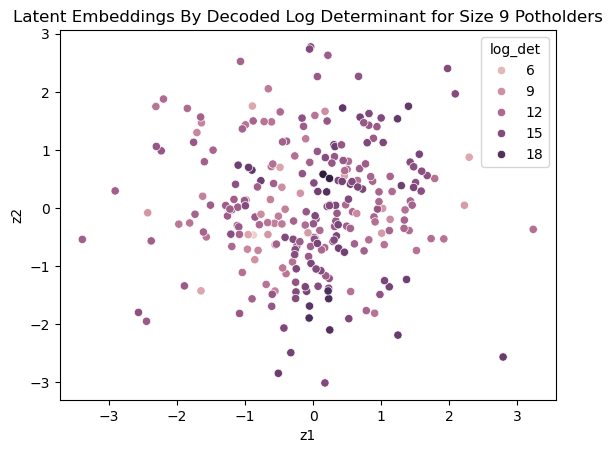

In [ ]:
plot_decoder_results(trained_model, 9, 3) # x and y 

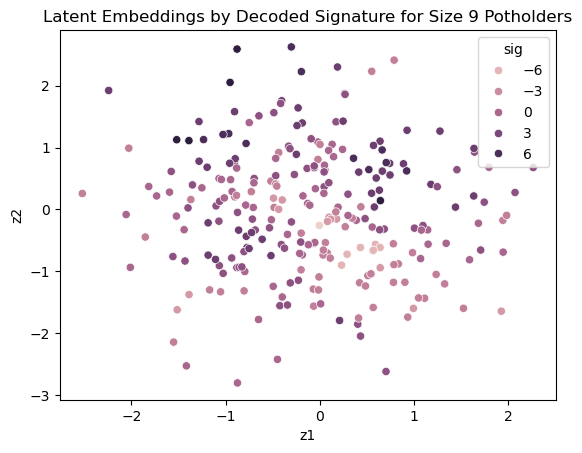

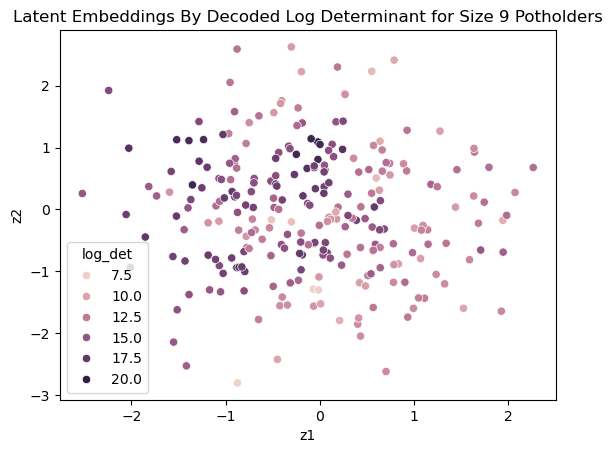

In [ ]:
plot_decoder_results(trained_model, 9, 3) # y and z